In [71]:
import json
import copy
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras_tuner
import pmdarima as pm
from tqdm import tqdm
from dataclasses import dataclass
from typing import List
from keras import layers, ops
from keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

from processing import Stationarizer, Normalizer
from plotting import visualize_loss, show_plot
from model_builder import build_model, build_spec_model, get_tuner, get_64_tuner

In [72]:
data = pd.read_csv("data/YF_IBM.csv")["Adj Close"]

train_idx = int(0.7 * np.shape(diff)[0])
val_idx = int(0.85 * np.shape(diff)[0])

train_data = data[:train_idx]
val_data = data[train_idx:val_idx]
non_test_data = data[:val_idx]
test_data = data[val_idx:]

train_arr = train_data.to_numpy().reshape((-1, 1))

<Axes: >

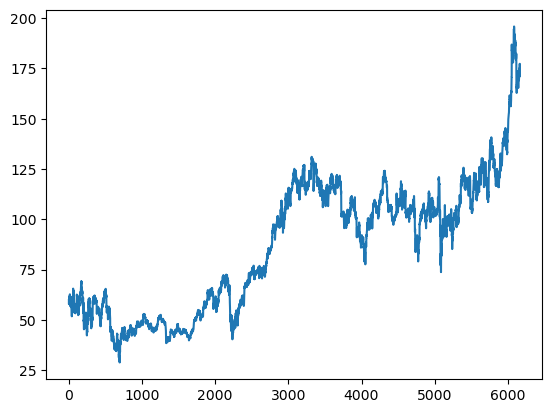

In [73]:
data.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

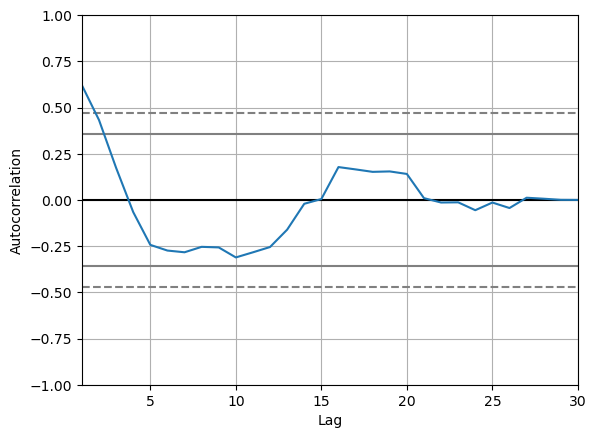

In [74]:
sc = StandardScaler()
train_sc = sc.fit_transform(train_arr)
#plt.plot(np.arange(sta.shape[0]), sta)
autocorrelation_plot(train_data[:30])

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 4314
Model:                ARIMA(10, 1, 0)   Log Likelihood               -6512.950
Date:                Sat, 10 Aug 2024   AIC                          13047.900
Time:                        21:19:19   BIC                          13117.963
Sample:                             0   HQIC                         13072.641
                               - 4314                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0150      0.011     -1.323      0.186      -0.037       0.007
ar.L2         -0.0130      0.012     -1.061      0.289      -0.037       0.011
ar.L3         -0.0103      0.013     -0.807      0.4

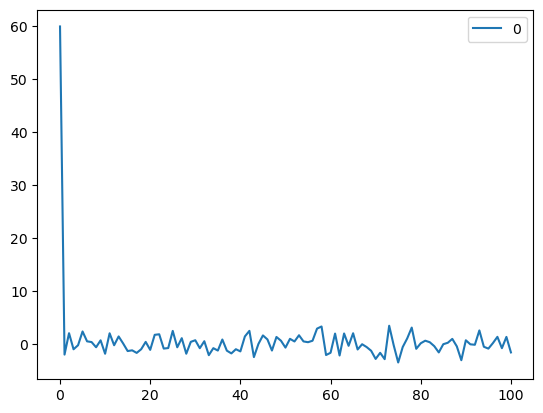

In [80]:
##### fit model
model = ARIMA(train_data, order=(10,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.loc[:100].plot()
plt.show()

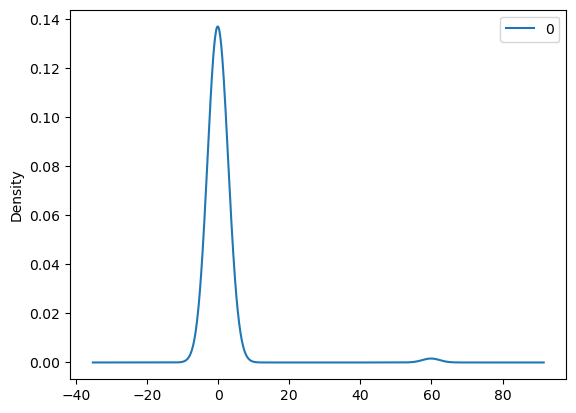

                 0
count  4314.000000
mean      0.029887
std       1.424926
min     -10.383616
25%      -0.498538
50%       0.019848
75%       0.555968
max      59.880375


In [76]:
# density plot of residuals
residuals.loc[:100].plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [82]:
history = train_data.to_list()
print(history)
true = val_data.to_numpy()
preds = []
for step in tqdm(true):
    model = ARIMA(history, order=(3, 1, 0))
    model_fit = model.fit()
    preds.append(model_fit.forecast())
    history.append(step)

[59.88037490844727, 57.84780502319336, 59.88037490844727, 58.847957611083984, 58.589881896972656, 60.91279220581055, 61.42900466918945, 61.687110900878906, 61.0418701171875, 61.75166320800781, 59.75130081176758, 61.687110900878906, 61.42900466918945, 62.71953201293945, 62.71953201293945, 61.49357223510742, 60.26752853393555, 58.589881896972656, 57.58969879150391, 57.944580078125, 56.78311920166016, 58.589881896972656, 60.46111297607422, 59.68680191040039, 58.91246795654297, 61.39677810668945, 60.6539306640625, 61.55829620361328, 59.62043380737305, 59.97570037841797, 60.5247688293457, 59.81419372558594, 60.33097076416016, 58.13475799560547, 57.3596305847168, 56.19694519042969, 57.10125732421875, 55.80937957763672, 54.000789642333984, 53.096439361572266, 51.8045539855957, 53.29021453857422, 55.80937957763672, 53.25791931152344, 53.2256088256836, 54.905067443847656, 55.80937957763672, 54.38833236694336, 55.64793014526367, 56.13237762451172, 55.29264068603516, 56.32612609863281, 56.8429069

100%|█████████████████████| 925/925 [03:39<00:00,  4.21it/s]


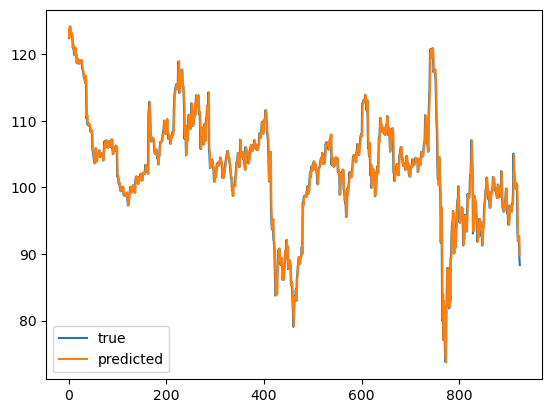

In [83]:
x = np.arange(true.shape[0])
plt.plot(x, true, label="true")
plt.plot(x, preds, label="predicted")
plt.legend()